In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Conv1D, TimeDistributed, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1_l2

In [3]:
file_path = 'Dataset Path'
data = pd.read_csv(file_path)

In [4]:
data.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
0,Alkoholunfälle,insgesamt,2023,202301,NaN,NaN,NaN,NaN,NaN
1,Alkoholunfälle,insgesamt,2023,202302,NaN,NaN,NaN,NaN,NaN
2,Alkoholunfälle,insgesamt,2023,202303,NaN,NaN,NaN,NaN,NaN
3,Alkoholunfälle,insgesamt,2023,202304,NaN,NaN,NaN,NaN,NaN
4,Alkoholunfälle,insgesamt,2023,202305,NaN,NaN,NaN,NaN,NaN


In [5]:
min_year = data['JAHR'].min()
max_year = data['JAHR'].max()

print(f"Minimum year in the dataset: {min_year}")
print(f"Maximum year in the dataset: {max_year}")

Minimum year in the dataset: 2000
Maximum year in the dataset: 2023


In [6]:
data['MONAT'] = data['MONAT'].astype(str).str[:6]
data['DATUM'] = pd.to_datetime(data['MONAT'], format='%Y%m')
data = data[data['JAHR'] <= 2020]

In [7]:
data.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT,DATUM
36,Alkoholunfälle,insgesamt,2020,202001,28.0,22.0,-20.00,27.27,37.0,2020-01-01
37,Alkoholunfälle,insgesamt,2020,202002,40.0,28.0,42.86,42.86,38.0,2020-02-01
38,Alkoholunfälle,insgesamt,2020,202003,27.0,34.0,-32.50,-20.59,37.0,2020-03-01
39,Alkoholunfälle,insgesamt,2020,202004,26.0,36.0,-3.70,-27.78,36.0,2020-04-01
40,Alkoholunfälle,insgesamt,2020,202005,40.0,39.0,53.85,2.56,36.0,2020-05-01


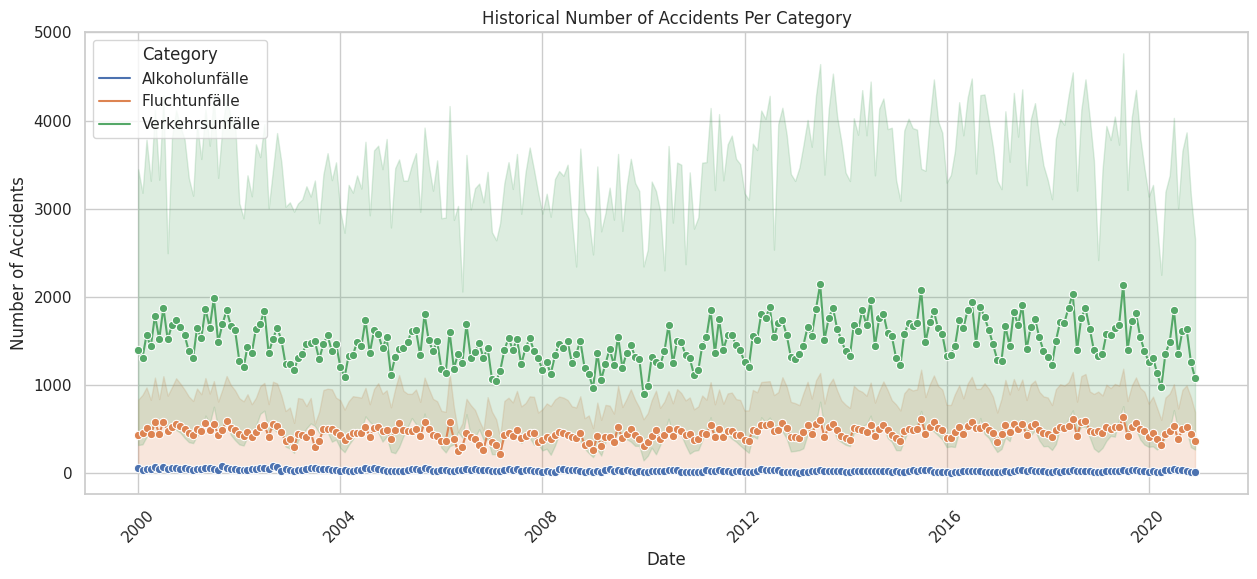

In [8]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 6))
sns.lineplot(x='DATUM', y='WERT', hue='MONATSZAHL', data=data, marker='o')
plt.title('Historical Number of Accidents Per Category')
plt.xlabel('Date')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.legend(title='Category', loc='upper left')
plt.show()

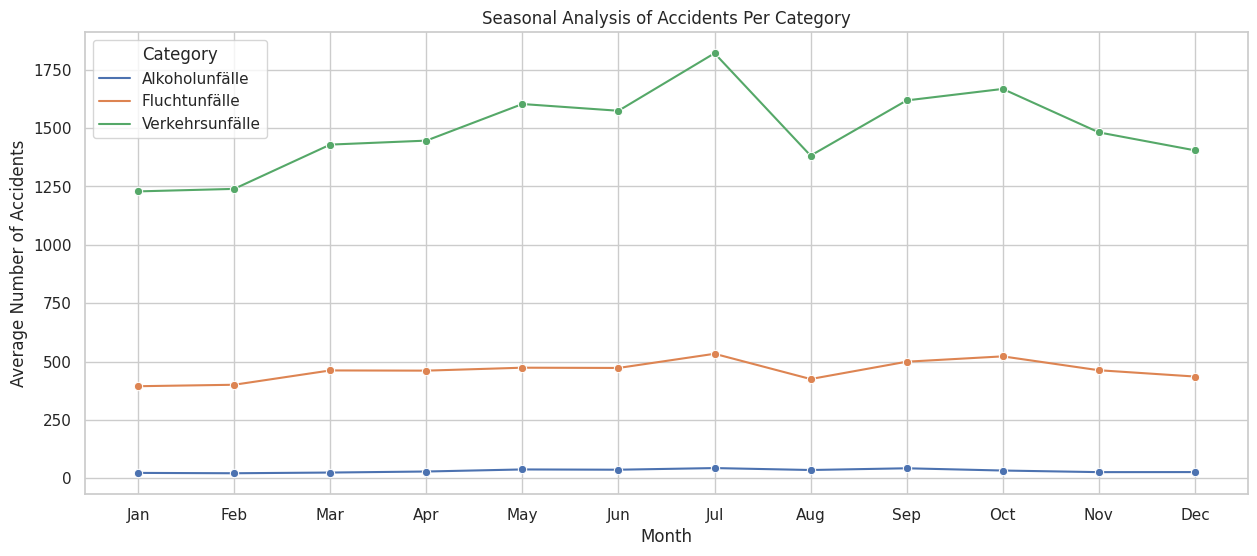

In [9]:
monthly_data = data.groupby(['MONATSZAHL', data['DATUM'].dt.month])['WERT'].mean().reset_index()
plt.figure(figsize=(15, 6))
sns.lineplot(x='DATUM', y='WERT', hue='MONATSZAHL', data=monthly_data, marker='o')
plt.title('Seasonal Analysis of Accidents Per Category')
plt.xlabel('Month')
plt.ylabel('Average Number of Accidents')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Category', loc='upper left')
plt.show()

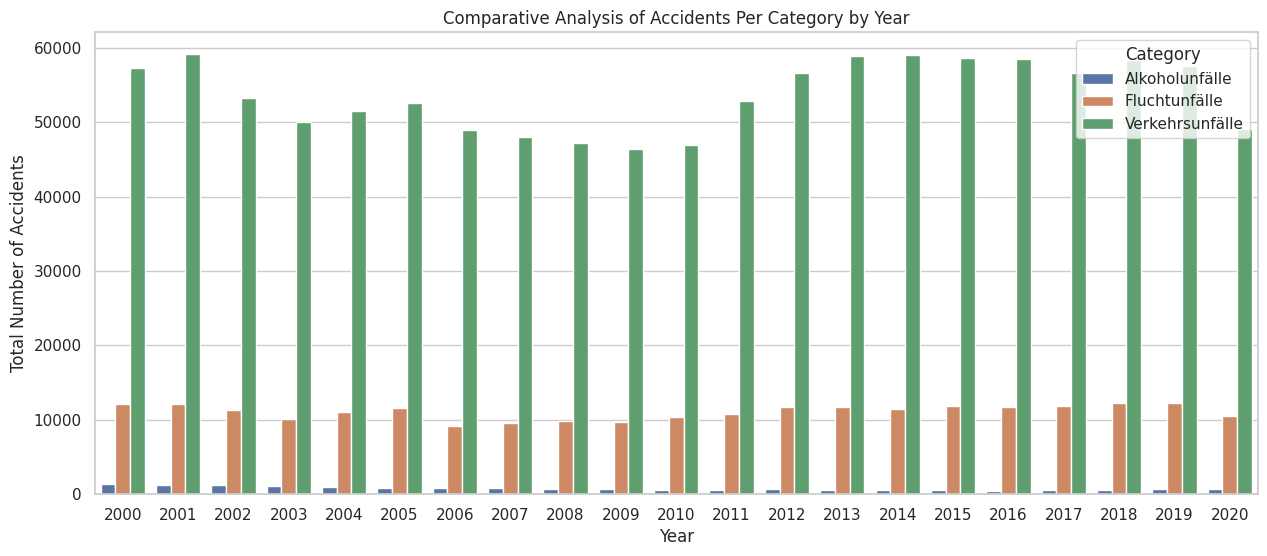

In [10]:
yearly_data = data.groupby(['MONATSZAHL', 'JAHR'])['WERT'].sum().reset_index()
plt.figure(figsize=(15, 6))
sns.barplot(x='JAHR', y='WERT', hue='MONATSZAHL', data=yearly_data)
plt.title('Comparative Analysis of Accidents Per Category by Year')
plt.xlabel('Year')
plt.ylabel('Total Number of Accidents')
plt.legend(title='Category', loc='upper right')
plt.show()

In [11]:
filtered_data = data[(data['MONATSZAHL'] == 'Alkoholunfälle') & (data['AUSPRAEGUNG'] == 'insgesamt') & (data['JAHR'] <= 2020)]
series = filtered_data.set_index('DATUM')['WERT'].dropna().values.reshape(-1, 1)

In [12]:
series_reshaped = series.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(series_reshaped)

def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length + 1])
    return np.array(sequences)

sequence_length = 5 
sequences = create_sequences(scaled_data, sequence_length)
X, y = sequences[:, :-1], sequences[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(100, return_sequences=True),
    LSTM(100),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

history_1 = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

predicted = model.predict(X_test)

predicted = scaler.inverse_transform(predicted)

Epoch 1/100
6/6 [==============================] - 15s 668ms/step - loss: 0.1164 - val_loss: 0.0447
Epoch 2/100
6/6 [==============================] - 0s 51ms/step - loss: 0.0362 - val_loss: 0.0465
Epoch 3/100
6/6 [==============================] - 0s 81ms/step - loss: 0.0300 - val_loss: 0.0190
Epoch 4/100
6/6 [==============================] - 0s 67ms/step - loss: 0.0271 - val_loss: 0.0209
Epoch 5/100
6/6 [==============================] - 0s 63ms/step - loss: 0.0248 - val_loss: 0.0204
Epoch 6/100
6/6 [==============================] - 0s 56ms/step - loss: 0.0235 - val_loss: 0.0191
Epoch 7/100
6/6 [==============================] - 0s 76ms/step - loss: 0.0218 - val_loss: 0.0172
Epoch 8/100
6/6 [==============================] - 0s 26ms/step - loss: 0.0215 - val_loss: 0.0172
Epoch 9/100
6/6 [==============================] - 0s 26ms/step - loss: 0.0204 - val_loss: 0.0167
Epoch 10/100
6/6 [==============================] - 0s 27ms/step - loss: 0.0202 - val_loss: 0.0162
Epoch 11/100
6/6 

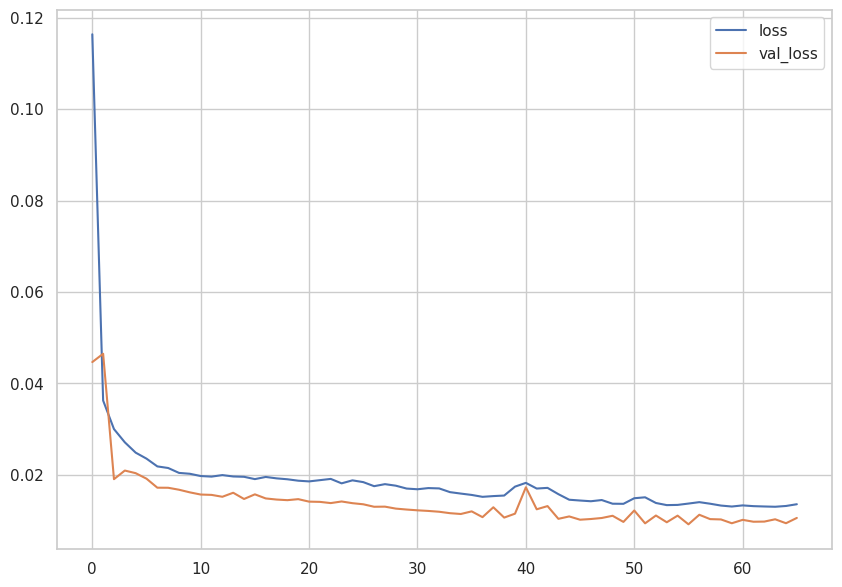

In [13]:
pd.DataFrame(history_1.history).plot(figsize=(10, 7));

In [14]:
y_test_original = scaler.inverse_transform(y_test)

comparison = pd.DataFrame({'Original': y_test_original.flatten(), 'Predicted': predicted.flatten()})
print(comparison)

    Original  Predicted
0       36.0  25.230030
1       13.0  31.158136
2       63.0  46.999088
3       39.0  39.055603
4       63.0  40.145855
5       40.0  39.408295
6       58.0  56.766308
7       25.0  28.697216
8       34.0  27.091068
9       66.0  73.511406
10     107.0  58.798004
11      61.0  42.288517
12      73.0  57.567310
13      48.0  48.967098
14      27.0  31.300261
15      63.0  62.548317
16     107.0  71.737526
17      47.0  39.277119
18      48.0  53.908028
19      39.0  33.156307
20      39.0  35.460480
21      22.0  35.869770
22      26.0  35.555542
23      21.0  29.173414
24      44.0  87.295883
25      51.0  49.141354
26      55.0  48.929085
27      36.0  32.162163
28      21.0  35.552677
29      43.0  39.118683
30      78.0  62.353291
31      77.0  75.819122
32      31.0  29.229916
33      51.0  35.852493
34      83.0  76.076782
35      35.0  37.685707
36      31.0  42.354309
37      52.0  56.703625
38      22.0  27.111073
39      20.0  26.770027
40      74.0  57

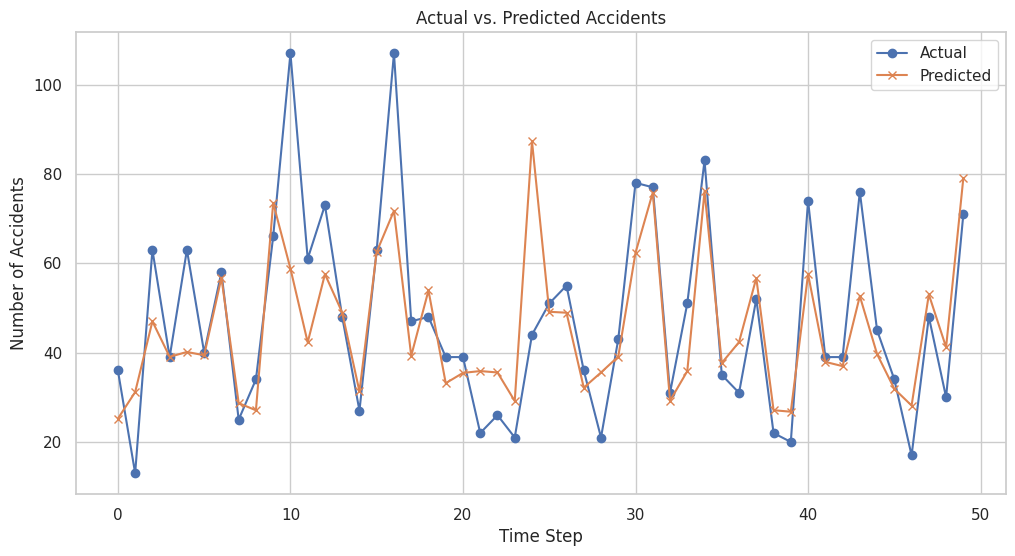

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label='Actual', marker='o')
plt.plot(predicted, label='Predicted', marker='x')
plt.title('Actual vs. Predicted Accidents')
plt.xlabel('Time Step')
plt.ylabel('Number of Accidents')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
model_2 = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    LSTM(128, return_sequences=False),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(1)
])

model_2.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

history_2 = model_2.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

predicted = model.predict(X_test)

predicted = scaler.inverse_transform(predicted)

Epoch 1/100
6/6 [==============================] - 10s 453ms/step - loss: 0.0875 - val_loss: 0.0688
Epoch 2/100
6/6 [==============================] - 0s 54ms/step - loss: 0.0390 - val_loss: 0.0626
Epoch 3/100
6/6 [==============================] - 0s 56ms/step - loss: 0.0264 - val_loss: 0.0394
Epoch 4/100
6/6 [==============================] - 0s 55ms/step - loss: 0.0212 - val_loss: 0.0394
Epoch 5/100
6/6 [==============================] - 0s 56ms/step - loss: 0.0172 - val_loss: 0.0375
Epoch 6/100
6/6 [==============================] - 0s 53ms/step - loss: 0.0162 - val_loss: 0.0353
Epoch 7/100
6/6 [==============================] - 0s 53ms/step - loss: 0.0163 - val_loss: 0.0355
Epoch 8/100
6/6 [==============================] - 0s 53ms/step - loss: 0.0147 - val_loss: 0.0333
Epoch 9/100
6/6 [==============================] - 0s 56ms/step - loss: 0.0133 - val_loss: 0.0359
Epoch 10/100
6/6 [==============================] - 0s 44ms/step - loss: 0.0143 - val_loss: 0.0335
Epoch 11/100
6/6 

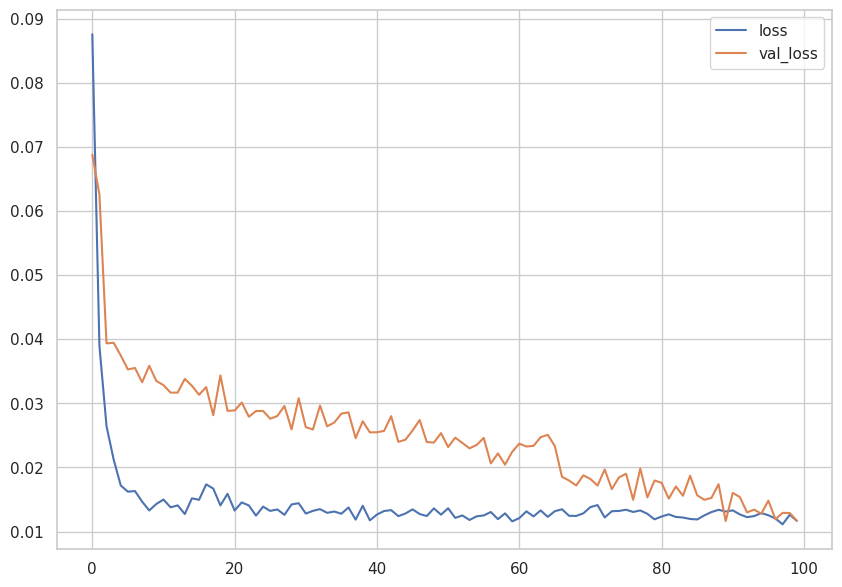

In [17]:
pd.DataFrame(history_2.history).plot(figsize=(10, 7));

In [18]:
y_test_original = scaler.inverse_transform(y_test)

comparison = pd.DataFrame({'Original': y_test_original.flatten(), 'Predicted': predicted.flatten()})
print(comparison)

    Original  Predicted
0       36.0  25.230030
1       13.0  31.158136
2       63.0  46.999088
3       39.0  39.055603
4       63.0  40.145855
5       40.0  39.408295
6       58.0  56.766308
7       25.0  28.697216
8       34.0  27.091068
9       66.0  73.511406
10     107.0  58.798004
11      61.0  42.288517
12      73.0  57.567310
13      48.0  48.967098
14      27.0  31.300261
15      63.0  62.548317
16     107.0  71.737526
17      47.0  39.277119
18      48.0  53.908028
19      39.0  33.156307
20      39.0  35.460480
21      22.0  35.869770
22      26.0  35.555542
23      21.0  29.173414
24      44.0  87.295883
25      51.0  49.141354
26      55.0  48.929085
27      36.0  32.162163
28      21.0  35.552677
29      43.0  39.118683
30      78.0  62.353291
31      77.0  75.819122
32      31.0  29.229916
33      51.0  35.852493
34      83.0  76.076782
35      35.0  37.685707
36      31.0  42.354309
37      52.0  56.703625
38      22.0  27.111073
39      20.0  26.770027
40      74.0  57

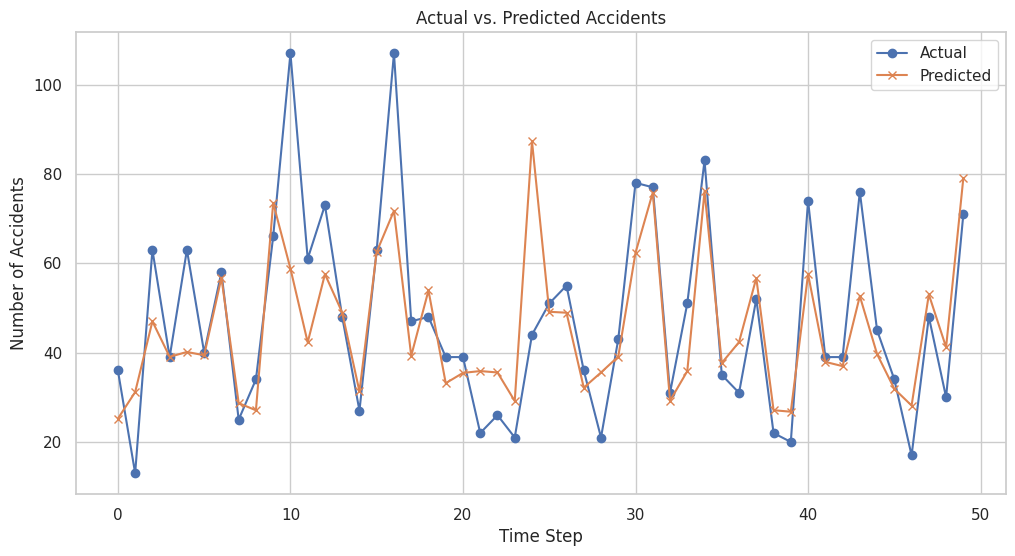

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label='Actual', marker='o')
plt.plot(predicted, label='Predicted', marker='x')
plt.title('Actual vs. Predicted Accidents')
plt.xlabel('Time Step')
plt.ylabel('Number of Accidents')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
model_3 = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)), input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    LSTM(128, return_sequences=False, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(1)
])

In [21]:
model_3.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

history_3 = model_3.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

predicted = model.predict(X_test)

predicted = scaler.inverse_transform(predicted)

Epoch 1/100
6/6 [==============================] - 15s 302ms/step - loss: 0.0927 - val_loss: 0.0962
Epoch 2/100
6/6 [==============================] - 0s 30ms/step - loss: 0.0618 - val_loss: 0.0912
Epoch 3/100
6/6 [==============================] - 0s 30ms/step - loss: 0.0480 - val_loss: 0.0714
Epoch 4/100
6/6 [==============================] - 0s 34ms/step - loss: 0.0439 - val_loss: 0.0646
Epoch 5/100
6/6 [==============================] - 0s 37ms/step - loss: 0.0407 - val_loss: 0.0583
Epoch 6/100
6/6 [==============================] - 0s 33ms/step - loss: 0.0412 - val_loss: 0.0561
Epoch 7/100
6/6 [==============================] - 0s 35ms/step - loss: 0.0384 - val_loss: 0.0541
Epoch 8/100
6/6 [==============================] - 0s 33ms/step - loss: 0.0376 - val_loss: 0.0553
Epoch 9/100
6/6 [==============================] - 0s 37ms/step - loss: 0.0367 - val_loss: 0.0494
Epoch 10/100
6/6 [==============================] - 0s 35ms/step - loss: 0.0334 - val_loss: 0.0496
Epoch 11/100
6/6 

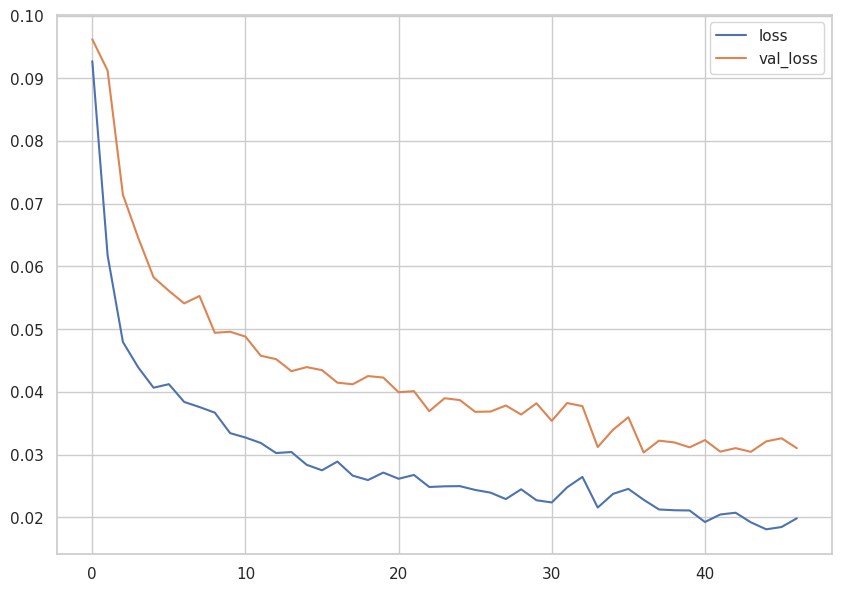

In [22]:
pd.DataFrame(history_3.history).plot(figsize=(10, 7));

In [23]:
y_test_original = scaler.inverse_transform(y_test)

comparison = pd.DataFrame({'Original': y_test_original.flatten(), 'Predicted': predicted.flatten()})
print(comparison)

    Original  Predicted
0       36.0  25.230030
1       13.0  31.158136
2       63.0  46.999088
3       39.0  39.055603
4       63.0  40.145855
5       40.0  39.408295
6       58.0  56.766308
7       25.0  28.697216
8       34.0  27.091068
9       66.0  73.511406
10     107.0  58.798004
11      61.0  42.288517
12      73.0  57.567310
13      48.0  48.967098
14      27.0  31.300261
15      63.0  62.548317
16     107.0  71.737526
17      47.0  39.277119
18      48.0  53.908028
19      39.0  33.156307
20      39.0  35.460480
21      22.0  35.869770
22      26.0  35.555542
23      21.0  29.173414
24      44.0  87.295883
25      51.0  49.141354
26      55.0  48.929085
27      36.0  32.162163
28      21.0  35.552677
29      43.0  39.118683
30      78.0  62.353291
31      77.0  75.819122
32      31.0  29.229916
33      51.0  35.852493
34      83.0  76.076782
35      35.0  37.685707
36      31.0  42.354309
37      52.0  56.703625
38      22.0  27.111073
39      20.0  26.770027
40      74.0  57

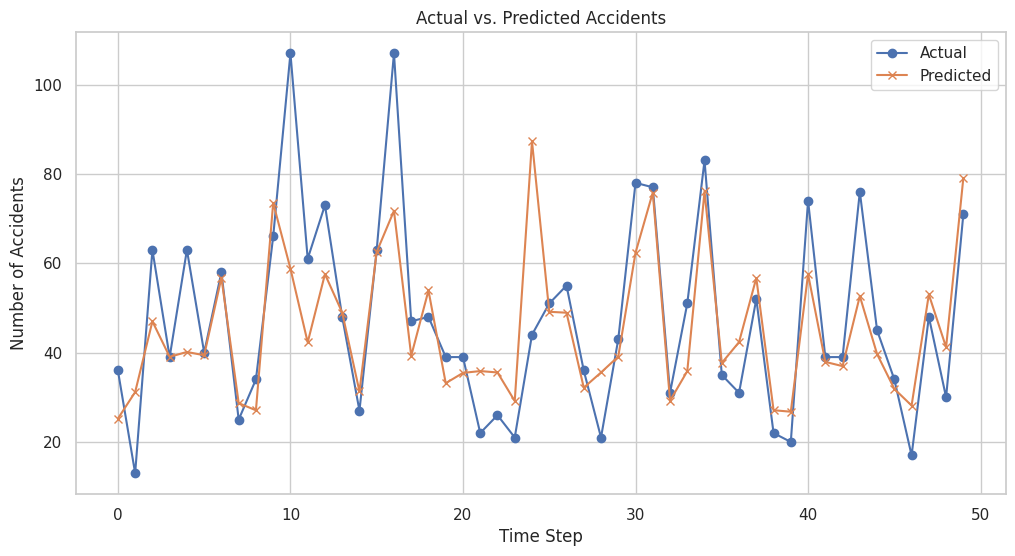

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label='Actual', marker='o')
plt.plot(predicted, label='Predicted', marker='x')
plt.title('Actual vs. Predicted Accidents')
plt.xlabel('Time Step')
plt.ylabel('Number of Accidents')
plt.legend()
plt.grid(True)
plt.show()